# Example 6: Liquid crystal

Liquid crystals are usually made from elongated organic molecules which are birrefringent. Those molecules tend to arrange in the same direction, identified by a vector refered as director vector. Then, they form a birrefringent material. It is possible to fabricate container materials that determine the molecules arrangement direction on their surface. These surfaces are refered as director sheets. Then, if two oposite director sheets present diferent director angles, the molecules in the middle of the liquid crystal tend to arrange their director vector so it varies linearly between one sheet and the other.

<img src="Liquid_crystal.png" width=969 >

Image taken from "Bistable nematic liquid crystal display device design", L. J. Cunnings, 2009. https://api.semanticscholar.org/CorpusID:3245275.

This material can be modelled by an infinite sum of infinitely thin layers with the same director vector. This allows calculating a Jones matrix for the liquid crystal, which will depend on the angles of the director sheets, the ordinary and extraordinary refractive indices of the dielectric crystal, its width and the light wavelength.

Then, if an electric field is applied to the liquid crystal, the molecules director vector rotates towards the electric field direction, which it reaches when for intense electric fields. This modfies the refractive index of the extraordinary component, varying the Jones matrix of the liquid crystal.

In this example we will study this model of liquid crystal.

In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import matplotlib.pyplot as plt

from py_pol import degrees, np
from py_pol.jones_vector import Jones_vector
from py_pol.jones_matrix import Jones_matrix, create_Jones_matrices

## Layer model

The layer model is the simplest one. It models the liquid crystal as a birrefringent material  with an infinite series of infinitesimal layers. Each layer is composed by molecules oriented in the same direction, i.e., their director vector is constant within the layer. The first and last layers present director vectors oriented according to their director sheets. Then, in the absence of electric field, the director vector of the layers within the first and last ones vary linearly but remaining perpendicular to propagation direction,

$\theta(z) = \theta_0 + (\theta_N - \theta_0) z / L,$

where $L$ is the total liquid crystal thickness. When the electric field is applied, usually as a voltage, all the molecules of the liquid crystal rotate a certain angle towards the propagation direction. This reduces the refractive index of the extraordinary component, thus reducing the layer retardance,

$n(V)=\left[\frac{\cos\beta(V)}{n_{e}^{2}}+\frac{\sin\beta(V)}{n_{o}^{2}}\right]^{-1/2},$

where $\beta(V)$ is the rotation angle towards propagation direction induced by the voltage, $V$. In this model, the director vector rotation toards the propagation direction is the same for all layers, so the extraordinary index depends only on the aplied voltage.

Finally, the Jones matrix of the liquid crystal is the product of the Jones matrices of all layers. The result becomes more accurate as the number of layer increases.

In [2]:
def rotation_linear(voltage=0, Vsat=25, out_number=True):
    """This function models a director vector rotation linear with the applied voltage up to the saturation voltage, where the rotation is 90º.
    
    Parameters:
        voltage (np.ndarray or float): Array of voltages.
        Vsat (float): Saturation voltage.
        out_number (bool): If True and voltage has only one element, transform array into float.

    Returns:
        rotation (np.ndarray or float): Array of director vector rotation angles.
    """
    rotation = np.minimum(np.abs(voltage), Vsat) * np.pi / (2 * Vsat)
    if out_number and isinstance(rotation, np.ndarray) and rotation.size == 1:
        rotation = rotation[0]
    return rotation

def liquid_crystal_LM(ne, no=1, az_0=0, az_f=90*degrees, rot_function=rotation_linear, rot_args=[0], thickness=1e-3, wavelength=632.8e-9, Nlayers=100):
    """This function simulates the liquid crystal using the layer model.
    
    Parameters:
        ne (float or numpy.ndarray): Extraordinary refractive index. Coincides with the refractive index for x component when azimuth is 0.
        no (float or numpy.ndarray): Ordinary refractive index. Coincides with the efractive index for y component when azimuth is 0. Default: 1.
        az_0 (float or numpy.ndarray): Azimuth of initial director sheet. Default: 0.
        az_f (float or numpy.ndarray): Azimuth of final director sheet. Default: 90 degrees.
        rot_function (function): Function to calculate the rotation angle of the director vector towards propagation direction. Default: rotation_linear.
        rot_params (list): List of arguments of rot_function. Default: [0].
        thickness (float or numpy.ndarray): Thickness of the sheet in the same units as wavelength. Default: 1 mm.
        wavelength (float or numpy.ndarray): Wavelength of the illumination in the same units as thickness. Default: 632.8 nm.
        Nlayers (int): Number of layers. Default: 100.
        
    Returns:
        J: Liquid crystal Jones matrix."""
    # Calculate director vector azimuth
    azimuth = np.linspace(az_0, az_f, Nlayers)
    # Calculate rotation angle due to voltage
    rotation = rot_function(*rot_args)
    if isinstance(rotation, np.ndarray):
        rotation, azimuth = np.meshgrid(rotation, azimuth)
    # Create the object
    J = Jones_matrix()
    J.biaxial_material(ne=ne, no=no, azimuth=azimuth, rotation=rotation, thickness=thickness/Nlayers, wavelength=wavelength)
    J.prod(axis=0)
    return J


### Number of layers

Now we can check how many layers are necessary for an accurate result. We will measure the intensity of a linearly polarized beam across the liquid crystal and a second polarizer. The intensity must reach a stable value.

Intensity for max. layers:  0.9999414838565023


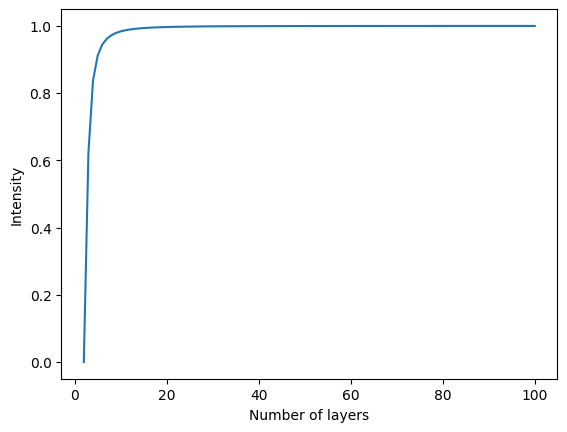

In [3]:
# Experiment elements
E0 = Jones_vector()
E0.linear_light(azimuth=0)
Pol = Jones_matrix()
Pol.diattenuator_perfect(azimuth=90*degrees)

# Loop in number of layers
N_layers = np.linspace(2, 100, 99, dtype=int)
I = np.zeros_like(N_layers, dtype=float)
for ind, N in enumerate(N_layers):
    # Create the liquid crystal
    Jlc = liquid_crystal_LM(ne=1.5011, no=1.5, az_0=0, az_f=90*degrees, thickness=5e-4, wavelength=632.8e-9, Nlayers=N)
    # Calculate the output
    Ef = Pol * (Jlc * E0)
    # Calculate the intensity
    I[ind] = Ef.parameters.intensity()

# Plot the intensity
plt.plot(N_layers, I)
plt.xlabel("Number of layers")
plt.ylabel("Intensity")
print("Intensity for max. layers: ", I[-1])



This graph shows that the final intensity stabilizes around 15-20 layers. We set the default number of layers to 100 to be safe.

In [4]:
Jlc.analysis.retarder(verbose=True)
Jlc.checks.is_diattenuator(verbose=True);


Analysis of Prod of J as retarder:

- Retardance of Prod of J is:
179.12341363339507

- Angles of Prod of J are:
  Alpha
45.0
  Delay
89.18967289323932
  Azimuth
44.99999999999988
  Ellipticity
44.59483644661975

Prod of J is an homogeneous diattenuator:
[False]



In this model, the global matrix of the liquid crystal behaves as a pure retarder with circular eigenstates (the ellipticity is not perfectly 45º, but it tends to it as $N\rightarrow\infty$).

### Voltages

Now we will introduce several voltages and will calculate the transmission as the molecules rotate. In order to simplify the model, we will consider that molecules rotation angle is proportional to applied voltage.

Text(0, 0.5, 'Intensity')

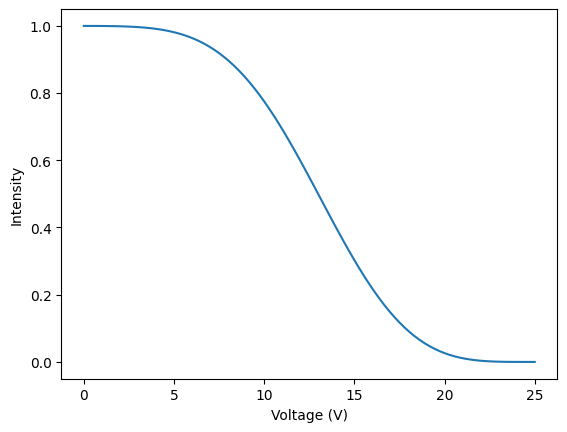

In [5]:
# Experiment elements
E0 = Jones_vector()
E0.linear_light(azimuth=0)
Pol = Jones_matrix()
Pol.diattenuator_perfect(azimuth=90*degrees)

# Loop in number of layers
voltages = np.linspace(0, 25, 91)
# Calculate the output
Jlc = liquid_crystal_LM(ne=1.5011, no=1.5, az_0=0, az_f=90*degrees, rot_args=[voltages], thickness=5e-4, wavelength=632.8e-9, Nlayers=50)
# print(Jlc.M)
Ef = Pol * (Jlc * E0)
# Calculate the intensity
I_LM = Ef.parameters.intensity()

# Plot the intensity
plt.plot(voltages, I_LM)
plt.xlabel("Voltage (V)")
plt.ylabel("Intensity")

Here we see that as rotation increases, the molecules retardance decreases and the intensity reaches a final value of 0 when there is no retardance.

# Coy model

Coy model is a bit more complex than pure layer model. In the layer model the director vector linearly rotates for all layers between the first and last layers. In Coy model, the layers close to the director plates do not rotate:

$\theta(z)=\left\{ \begin{array}{c}
\theta_{0}\;\;\;\;z\leq d\\
\theta_{N}\;\;\;z\geq L-d\\
\theta_{0}+(\theta_{N}-\theta_{0})\frac{z-d}{L-d}\;\;\;d<z<L-d
\end{array}\right.,$

being $d$ the distance from the director sheets where the liquid crystal layers director vector start to rotate.

In [ ]:
def liquid_crystal_Coy(ne, no=1, az_0=0, az_f=90*degrees, rot_function=rotation_linear, rot_args=[0], thickness=1e-3, d_norot=0, wavelength=632.8e-9, Nlayers=100):
    """This function simulates the liquid crystal using the Coy model.
    
    Parameters:
        ne (float or numpy.ndarray): Extraordinary refractive index. Coincides with the refractive index for x component when azimuth is 0.
        no (float or numpy.ndarray): Ordinary refractive index. Coincides with the efractive index for y component when azimuth is 0. Default: 1.
        az_0 (float or numpy.ndarray): Azimuth of initial director sheet. Default: 0.
        az_f (float or numpy.ndarray): Azimuth of final director sheet. Default: 90 degrees.
        rot_function (function): Function to calculate the rotation angle of the director vector towards propagation direction. Default: rotation_linear.
        rot_params (list): List of arguments of rot_function. Default: [0].
        thickness (float or numpy.ndarray): Thickness of the sheet in the same units as wavelength. Default: 1 mm.
        d_norot (float): No rotation distance. Default: 0.
        wavelength (float or numpy.ndarray): Wavelength of the illumination in the same units as thickness. Default: 632.8 nm.
        Nlayers (int): Number of layers. Default: 100.
        
    Returns:
        J: Liquid crystal Jones matrix."""
    # Calculate director vector azimuth
    azimuth = np.ones(Nlayers) * az_0
    z = np.linspace(0, thickness, Nlayers)
    cond_f = z >= thickness - d_norot
    if np.any(cond_f):
        azimuth[cond_f] = az_f
    cond_0 = z <= d_norot
    cond_var = np.logical_not(np.logical_or(cond_0, cond_f))
    if np.any(cond_var):
        aux = np.linspace(az_0, az_f, np.sum(cond_var))
        azimuth[cond_var] = aux
    # Calculate rotation angle due to voltage
    rotation = rot_function(*rot_args)
    if isinstance(rotation, np.ndarray):
        rotation, azimuth = np.meshgrid(rotation, azimuth)
    else:
        rotation = np.ones(Nlayers) * rotation
    # Rotation near to the director plates is 0
    cond = azimuth == az_0
    if np.any(cond):
        rotation[cond] = 0
    cond = azimuth == az_f
    if np.any(cond):
        rotation[cond] = 0
    # Create the object
    J = Jones_matrix()
    J.biaxial_material(ne=ne, no=no, azimuth=azimuth, rotation=rotation, thickness=thickness/Nlayers, wavelength=wavelength)
    J.prod(axis=0)
    return J


Let's see what happens without voltage for different no rotation thicknesses. We will use a for loop as this parameter should be constant for a given material.

Intensity for max. layers:  0.10984174696817403


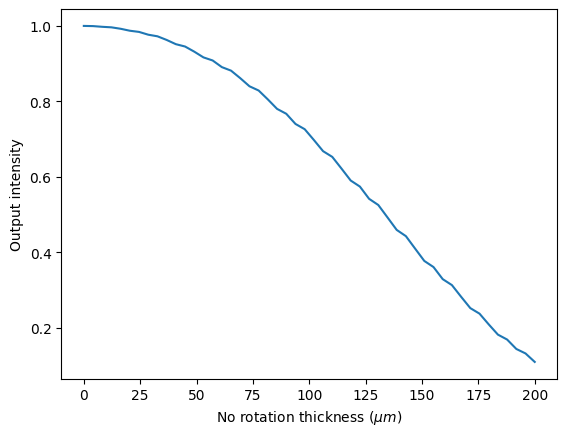

In [24]:
# Experiment elements
E0 = Jones_vector()
E0.linear_light(azimuth=0)
Pol = Jones_matrix()
Pol.diattenuator_perfect(azimuth=90*degrees)

# Loop in no rotation thickness
d_norot = np.linspace(0, 2e-4, 50)
I = np.zeros_like(d_norot, dtype=float)
for ind, d in enumerate(d_norot):
    # Create the liquid crystal
    Jlc = liquid_crystal_Coy(ne=1.5011, no=1.5, az_0=0, az_f=90*degrees, thickness=5e-4, d_norot=d, wavelength=632.8e-9, Nlayers=200)
    # Calculate the output
    Ef = Pol * (Jlc * E0)
    # Calculate the intensity
    I[ind] = Ef.parameters.intensity()

# Plot the intensity
plt.plot(d_norot * 1e6, I)
plt.xlabel("No rotation thickness ($\mu m$)")
plt.ylabel("Output intensity")
print("Intensity for max. layers: ", I[-1])

In this case it is necessary to increase the number of layers so the intensity distribution do not get distorted.

For comparing different models with different voltage, we will chose a value for the no rotation thickness so 10% of the molecules do not rotate.

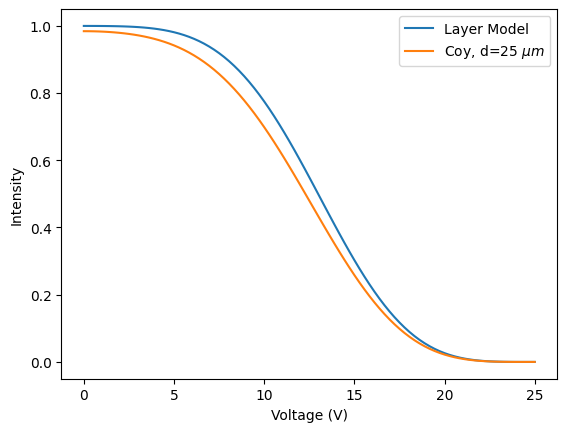

In [22]:
# Experiment elements
E0 = Jones_vector()
E0.linear_light(azimuth=0)
Pol = Jones_matrix()
Pol.diattenuator_perfect(azimuth=90*degrees)

# Loop in number of layers
voltages = np.linspace(0, 25, 91)
# Calculate the output
Jlc = liquid_crystal_Coy(ne=1.5011, no=1.5, az_0=0, az_f=90*degrees, rot_args=[voltages], thickness=5e-4, d_norot=2.5e-5, wavelength=632.8e-9, Nlayers=200)
# print(Jlc.M)
Ef = Pol * (Jlc * E0)
# Calculate the intensity
I_Coy = Ef.parameters.intensity()

# Plot the intensity
plt.plot(voltages, I_LM, label="Layer Model")
plt.plot(voltages, I_Coy, label="Coy, d=25 $\mu m$")
plt.xlabel("Voltage (V)")
plt.ylabel("Intensity")
plt.legend()

# Marquez model

Marquez model is a refinement of Coy model. The only difference is that the no rotation thickness depends on the voltage. So we will define a new function for it.

In [40]:
def no_rotation_thickness(voltage=0, Vsat=25, d_max=5e-5, out_number=True):
    """This function models a no rotation thickness linear with the applied voltage up to the saturation voltage, where the no rotation thickness reaches its maximum value.
    
    Parameters:
        voltage (np.ndarray or float): Array of voltages. Default: 0.
        Vsat (float): Saturation voltage. Default: 25 V.
        d_max (float): Maximum no rotation thickness. Default: 50 um.
        out_number (bool): If True and voltage has only one element, transform array into float. Default: True.

    Returns:
        d (np.ndarray or float): Array of no rotation thickness.
    """
    d = np.minimum(np.abs(voltage), Vsat) * d_max / Vsat
    if out_number and isinstance(d, np.ndarray) and d.size == 1:
        d = d[0]
    return d
    
def liquid_crystal_Marquez(ne, no=1, az_0=0, az_f=90*degrees, rot_function=rotation_linear, rot_args=[], thickness=1e-3, norot_function=no_rotation_thickness, norot_args=[], voltages=np.ndarray([0]), wavelength=632.8e-9, Nlayers=100):
    """This function simulates the liquid crystal using the layer model.
    
    Parameters:
        ne (float or numpy.ndarray): Extraordinary refractive index. Coincides with the refractive index for x component when azimuth is 0.
        no (float or numpy.ndarray): Ordinary refractive index. Coincides with the efractive index for y component when azimuth is 0. Default: 1.
        az_0 (float or numpy.ndarray): Azimuth of initial director sheet. Default: 0.
        az_f (float or numpy.ndarray): Azimuth of final director sheet. Default: 90 degrees.
        rot_function (function): Function to calculate the rotation angle of the director vector towards propagation direction. Default: rotation_linear.
        rot_params (list): List of arguments of rot_function. Default: [].
        thickness (float or numpy.ndarray): Thickness of the sheet in the same units as wavelength. Default: 1 mm.
        norot_function (function): No rotation thickness function. Default: no_rotation_thickness.
        norot_params (list): List of arguments of norot_function. Default: [].
        voltages (float or numpy.ndarray): Array of voltages. Default: [0].
        wavelength (float or numpy.ndarray): Wavelength of the illumination in the same units as thickness. Default: 632.8 nm.
        Nlayers (int): Number of layers. Default: 100.
        
    Returns:
        J: Liquid crystal Jones matrix."""
    # Calculate director vector azimuth
    azimuth = np.ones((Nlayers, voltages.size)) * az_0
    rotation = np.zeros((Nlayers, voltages.size))
    for ind,v in enumerate(voltages):
        aux = np.ones(Nlayers) * az_0
        args = [v] + norot_args
        d_norot = norot_function(*args)
        z = np.linspace(0, thickness, Nlayers)
        cond_f = z >= thickness - d_norot
        if np.any(cond_f):
            aux[cond_f] = az_f
        cond_0 = z <= d_norot
        cond_var = np.logical_not(np.logical_or(cond_0, cond_f))
        if np.any(cond_var):
            aux2 = np.linspace(az_0, az_f, np.sum(cond_var))
            aux[cond_var] = aux2
        azimuth[:,ind] = aux
        # Calculate rotation angle due to voltage
        args = [v] + rot_args
        aux = rot_function(*args)
        rotation[:,ind] = aux

    # Rotation near to the director plates is 0
    cond = azimuth == az_0
    if np.any(cond):
        rotation[cond] = 0
    cond = azimuth == az_f
    if np.any(cond):
        rotation[cond] = 0
    # Create the object
    J = Jones_matrix()
    J.biaxial_material(ne=ne, no=no, azimuth=azimuth, rotation=rotation, thickness=thickness/Nlayers, wavelength=wavelength)
    J.prod(axis=0)
    return J


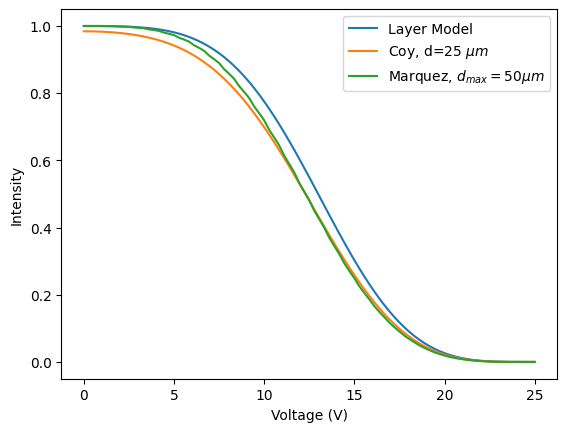

In [42]:
# Experiment elements
E0 = Jones_vector()
E0.linear_light(azimuth=0)
Pol = Jones_matrix()
Pol.diattenuator_perfect(azimuth=90*degrees)

# Loop in number of layers
voltages = np.linspace(0, 25, 91)
# Calculate the output
Jlc = liquid_crystal_Marquez(ne=1.5011, no=1.5, az_0=0, az_f=90*degrees, voltages=voltages, thickness=5e-4, norot_args=[25, 5e-5], wavelength=632.8e-9, Nlayers=300)
# print(Jlc.M)
Ef = Pol * (Jlc * E0)
# Calculate the intensity
I_Marquez = Ef.parameters.intensity()

# Plot the intensity
plt.plot(voltages, I_LM, label="Layer Model")
plt.plot(voltages, I_Coy, label="Coy, d=25 $\mu m$")
plt.plot(voltages, I_Marquez, label="Marquez, $d_{max}=50 \mu m$")
plt.xlabel("Voltage (V)")
plt.ylabel("Intensity")
plt.legend()

This model, which is mor ecomples, again needs more layers to give a smooth intensity plot. Its result is similar to the layer model for low voltages (as the no thickness rotation is small) and converges with Coy model for large voltages.